In [2]:
import re
def encode_label(label_list: list) -> (list, list):
    label_name = [[] for i in range(5)]

    label_encoded_list = []

    for label in label_list:
        if label is None:
            label_encoded_list.append(None)
            continue
        label_encoded = []

        for i in range(len(label) - 1):
            if not label[i] in label_name[i]:
                label_name[i].append(label[i])
                label_encoded.append(len(label_name[i]) - 1)
            else:
                label_encoded.append(label_name[i].index(label[i]))

        if label[4] is None:
            label_encoded.append([None])
        else:
            prop = []
            for ll in label[4]:
                if not ll in label_name[4]:
                    label_name[4].append(ll)
                    prop.append(len(label_name[4]) - 1)
                else:
                    prop.append(label_name[4].index(ll))
            label_encoded.append(prop)

        label_encoded_list.append(label_encoded)
    return label_name, label_encoded_list


def read_label(path: str) -> (list, list):
    label_list = []
    img_name = []
    with open(path, "r") as f:
        r = f.readline()
        while r:
            img_name.append(r[:5].strip())
            t = re.search('_missing descriptor', r)
            if t is not None:
                label_list.append(None)
                r = f.readline()
                continue
            else:
                label1 = []
                pattern = re.compile(r'\((.*?)\)')
                t = pattern.findall(r)
                for s in t[0:-1]:
                    c = s.split(" ")[-1].strip()
                    label1.append(c)

                pattern = re.compile(r'\'\((.*?)\)')
                t = pattern.findall(r)[0].strip()
                if not t == '':
                    prop = []
                    t = t.split(" ")
                    for i in t:
                        prop.append(i)
                    label1.append(prop)
                else:
                    label1.append(None)
            label_list.append(label1)
            r = f.readline()
    return label_list, img_name


def one_hot_prop(label_encoded_list: list, prop_num: int) -> list:
    label_list = []
    iii = 0
    for label in label_encoded_list:
        iii += 1
        if label is not None:
            prop_one_hot = [0 for i in range(prop_num)]
            prop = label.pop()
            for i in prop:
                if i is not None:
                    prop_one_hot[i] = 1
            label.append(prop_one_hot)
            label_list.append(label)
            if 1 in prop_one_hot:
                pass
        else:
            label_list.append(None)
    return label_list


def one_hot(index, num):
    label_one_hot = [0 for i in range(num)]
    label_one_hot[index] = 1
    return label_one_hot


def one_hot_label(label_list: list, label_name) -> list:
    label_one_hot = []
    for label in label_list:
        if label is not None:
            l = []
            for i in range(len(label_name) - 1):
                o = one_hot(label[i], len(label_name[i]))
                l += o
            l += label[-1]
        else:
            label_one_hot.append(None)
            continue
        label_one_hot.append(l)
    return label_one_hot


def label_pre_one_hot(path1, path2):
    label_list1, img_name1 = read_label(path1)
    # print(len(img_name1))
    label_list2, img_name2 = read_label(path2)
    # print(len(img_name2))
    label_list = label_list1 + label_list2

    male = 0
    total = 0

    # for label in label_list:
    #     if label is not None:
    #         total += 1
    #         if label[0] == 'male':
    #             male += 1
    # print(male, total)

    img_name = img_name1 + img_name2
    label_name, label_encoded_list = encode_label(label_list)
    prop_num = len(label_name[-1])
    label_list = one_hot_prop(label_encoded_list, prop_num)
    label_one_hot = one_hot_label(label_list, label_name)

    return label_one_hot, img_name, label_name


In [6]:
def kNNClassify(inX, dataSet, labels, k ):
    distance = np.sum(np.power((dataSet - inX), 2), axis = 1) # 计算欧几里得距离
    sortedArray = np.argsort(distance, kind = "quicksort")[:k]
    # 给距离加入权重
    w = []
    for i in range(k):
        w.append((distance[sortedArray[k-1]] - distance[sortedArray[i]]) / (distance[sortedArray[k-1]] - distance[sortedArray[0]]))
 
    count = np.zeros(893)
    temp = 0
    for each in sortedArray:
        count[labels[each]] += 1 + w[temp]
        temp += 1
 
    label = np.argmax(count) # 如果label中有多个一样的样本数，那么取第一个最大的样本类别
    return label

In [7]:
import raw_data_read_test as rd
import label_pre as lp
import cv2
from sklearn.neighbors import KNeighborsClassifier ###svm
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

# 训练集
channels = 1  # 图像的通道数，灰度图为1
path_rawdata = r"./rawdata"
path_label1 = r"./faceDR"
path_label2 = r"./faceDS"
label_one_hot,img_name,label_list = label_pre_one_hot(path_label1,path_label2)
img_list = rd.read_rawdata(channels, path_rawdata, img_name)  # 图片矩阵


n = 0
for i in range(len(label_list)):
    num = i - n
    if label_list[num] is None:
        del label_list[num]
        del img_name[num]
        n = n + 1

array_of_img = []
for img in img_list:
    if img is not None:
        img = img / 255.0
        img = cv2.resize(img, (100, 100))
        array_of_img.append(img)
train_images = np.array(array_of_img)
array_of_img = []

array_of_labels = []
for label in label_one_hot:
    if label is not None:
        append_label = label[0]
        array_of_labels.append(int(append_label))
train_labels = np.array(array_of_labels)
array_of_labels = []

# 划分数据集和测试集
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.1, random_state=3)

del train_images
del train_labels
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 特征降维
pca = PCA(n_components=85)
newX = pca.fit_transform(X_train)
xx = pca.transform(X_test)

print("特征提取成功")

数据缺失： 1228
数据缺失： 1232
数据缺失： 1808
数据缺失： 4056
数据缺失： 4135
数据缺失： 4136
数据缺失： 5004
特征提取成功


In [8]:
k_list = []
acc_list = []
m=20
correct_count = 0
test_number = xx.shape[0]
string = "test sample serial number: {0}, sample label: {1}, classify label: {2}------>correct?: {3}"
for k in range(1,m):
    for i in np.arange(test_number):
        label =  kNNClassify(xx[i], newX, y_train, k)
        if label == y_test[i]:
            correct_count += 1
        #print(string.format(i + 1, y_test[i], label, label == y_test[i]))
        acc=(correct_count / test_number) * 100
    correct_count = 0
    print("k=",k,"时,""加权KNN训练准确率: ",acc,"%")
    k_list.append(k)
    acc_list.append(acc)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12452\2971547111.py:7: RuntimeWarning: invalid value encountered in double_scalars
  w.append((distance[sortedArray[k-1]] - distance[sortedArray[i]]) / (distance[sortedArray[k-1]] - distance[sortedArray[0]]))


k= 1 时,加权KNN训练准确率:  86.21399176954732 %
k= 2 时,加权KNN训练准确率:  86.21399176954732 %
k= 3 时,加权KNN训练准确率:  84.77366255144034 %
k= 4 时,加权KNN训练准确率:  85.39094650205762 %
k= 5 时,加权KNN训练准确率:  83.9506172839506 %
k= 6 时,加权KNN训练准确率:  82.71604938271605 %
k= 7 时,加权KNN训练准确率:  82.3045267489712 %
k= 8 时,加权KNN训练准确率:  81.6872427983539 %
k= 9 时,加权KNN训练准确率:  82.3045267489712 %
k= 10 时,加权KNN训练准确率:  81.27572016460906 %
k= 11 时,加权KNN训练准确率:  81.89300411522635 %
k= 12 时,加权KNN训练准确率:  82.51028806584361 %
k= 13 时,加权KNN训练准确率:  82.3045267489712 %
k= 14 时,加权KNN训练准确率:  81.06995884773663 %
k= 15 时,加权KNN训练准确率:  80.04115226337449 %
k= 16 时,加权KNN训练准确率:  80.65843621399176 %
k= 17 时,加权KNN训练准确率:  80.04115226337449 %
k= 18 时,加权KNN训练准确率:  80.8641975308642 %
k= 19 时,加权KNN训练准确率:  79.62962962962963 %


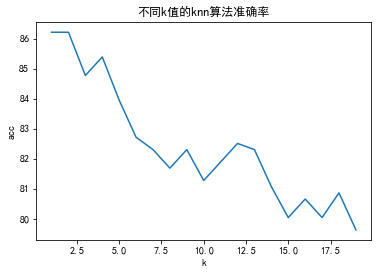

In [9]:
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.xlabel('k')
plt.ylabel('acc')
plt.title('不同k值的knn算法准确率')
plt.plot(k_list,acc_list)

In [10]:
print(acc_list)

[86.21399176954732, 86.21399176954732, 84.77366255144034, 85.39094650205762, 83.9506172839506, 82.71604938271605, 82.3045267489712, 81.6872427983539, 82.3045267489712, 81.27572016460906, 81.89300411522635, 82.51028806584361, 82.3045267489712, 81.06995884773663, 80.04115226337449, 80.65843621399176, 80.04115226337449, 80.8641975308642, 79.62962962962963]
